In [10]:
import os
import gc
import importlib
from shutil import copy2
from hipe4ml.model_handler import ModelHandler
from sklearn.utils.class_weight import compute_sample_weight
from load_data import LoadData
from prepare_model import PrepareModel
import plotting_tools
from train_model import TrainModel

In [2]:
json_file_name = "test_config.json"
lower_p_cut, upper_p_cut = 0, 3
anti_particles = False
optimize_hyper_params = False
create_plots = True
save_plots = False
if anti_particles:
    model_name = f"model_{lower_p_cut:.1f}_{upper_p_cut:.1f}_anti"
else:
    model_name = f"model_{lower_p_cut:.1f}_{upper_p_cut:.1f}_positive"
data_file_name = LoadData.load_file_name(json_file_name, "training")

# loading data
print(f"\nLoading data from {data_file_name}\n")
loader = LoadData(
    data_file_name, json_file_name, lower_p_cut, upper_p_cut, anti_particles
)
tree_handler = loader.load_tree()
protons, kaons, pions = loader.get_protons_kaons_pions(tree_handler)
print(f"\nProtons, kaons, and pions loaded using file {data_file_name}\n")
pid_variable_name = LoadData.load_var_name(json_file_name, "pid")
del tree_handler
gc.collect()
# change location to specific folder for this model
json_file_path = os.path.join(os.getcwd(), json_file_name)
if not os.path.exists(f"{model_name}"):
    os.makedirs(f"{model_name}")
os.chdir(f"{model_name}")
copy2(json_file_path, os.getcwd())



Loading data from /Users/julnow/gsi/mgr/trees/PlainTree200k_trdrich_12agev.root


Protons, kaons, and pions loaded using file /Users/julnow/gsi/mgr/trees/PlainTree200k_trdrich_12agev.root



'/Users/julnow/gsi/ml_pid_cbm/ml-pid-cbm/ml_pid_cbm/model_0.0_3.0_positive/test_config.json'

In [3]:
# loading model handler
model_hdl = PrepareModel(json_file_name, optimize_hyper_params)
train_test_data = model_hdl.prepare_train_test_data(protons, kaons, pions)
features_for_train = model_hdl.load_features_for_train()
print("\nPreparing model handler\n")
model_hdl, study = model_hdl.prepare_model_handler(train_test_data=train_test_data)
# train model
train = TrainModel(model_hdl, model_name)
sample_weights = compute_sample_weight(
    class_weight="balanced", y=train_test_data[1]  # labels of training dataset
)
train.train_model_handler(train_test_data, sample_weights)
print("\nModel trained!")


Preparing model handler


ModelHandler ready using configuration from test_config.json
Training xgboost model for classification
Number of detected classes: 3
Training the model: ...
Training the model: Done!
Testing the model: ...
ROC_AUC_score: 0.999357
Testing the model: Done!

Model trained!


In [31]:
train_test_data[0][train_test_data[0].isna().any(axis=1)].columns

Index(['Complex_axis_a_rich', 'Complex_axis_b_rich',
       'Complex_chi2_ov_ndf_rich', 'Complex_chi2_vtx', 'Complex_eta',
       'Complex_id', 'Complex_mass', 'Complex_mass2', 'Complex_n_hits_rich',
       'Complex_nhits_trd', 'Complex_p', 'Complex_pT', 'Complex_phi',
       'Complex_phi_ellipse_rich', 'Complex_phi_rich', 'Complex_pid',
       'Complex_px', 'Complex_py', 'Complex_pz', 'Complex_q',
       'Complex_radial_angle_rich', 'Complex_radial_pos_rich',
       'Complex_radius_rich', 'Complex_rapidity', 'Complex_trd_proba_e',
       'Complex_trd_proba_k', 'Complex_trd_proba_p', 'Complex_trd_proba_pi'],
      dtype='object')

In [4]:
y_pred_test = model_hdl.predict(train_test_data[2], False)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


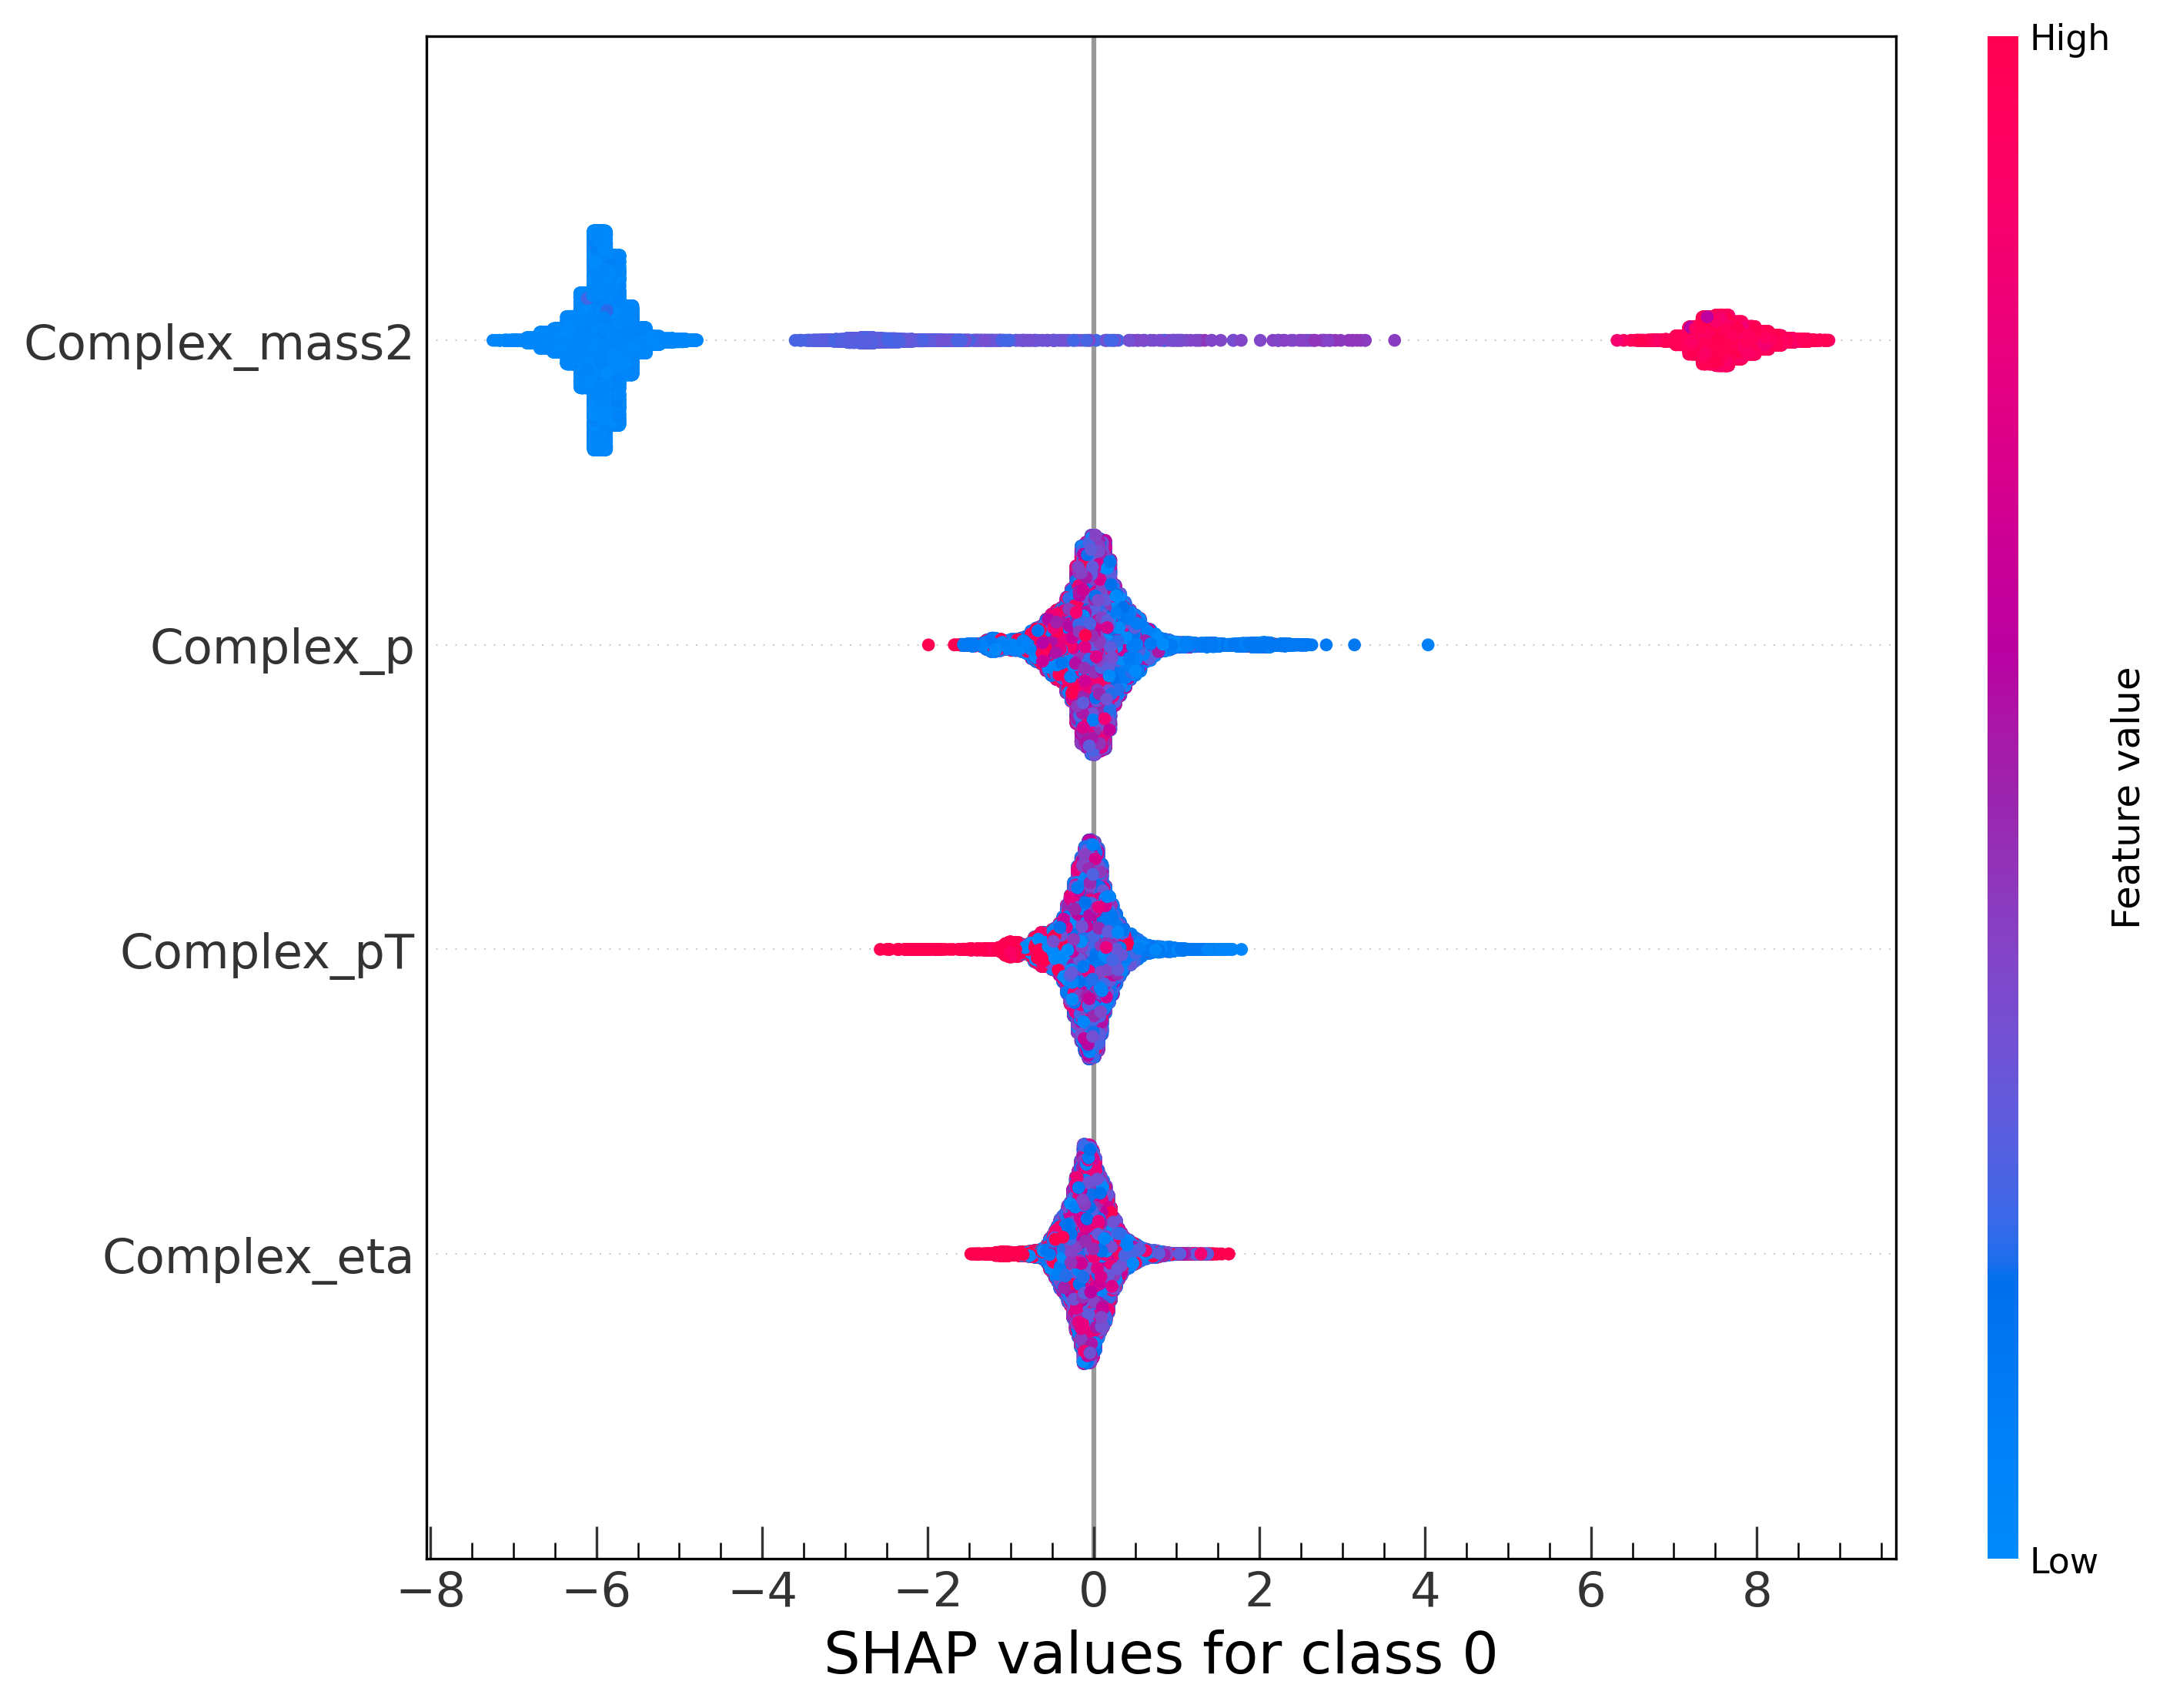

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


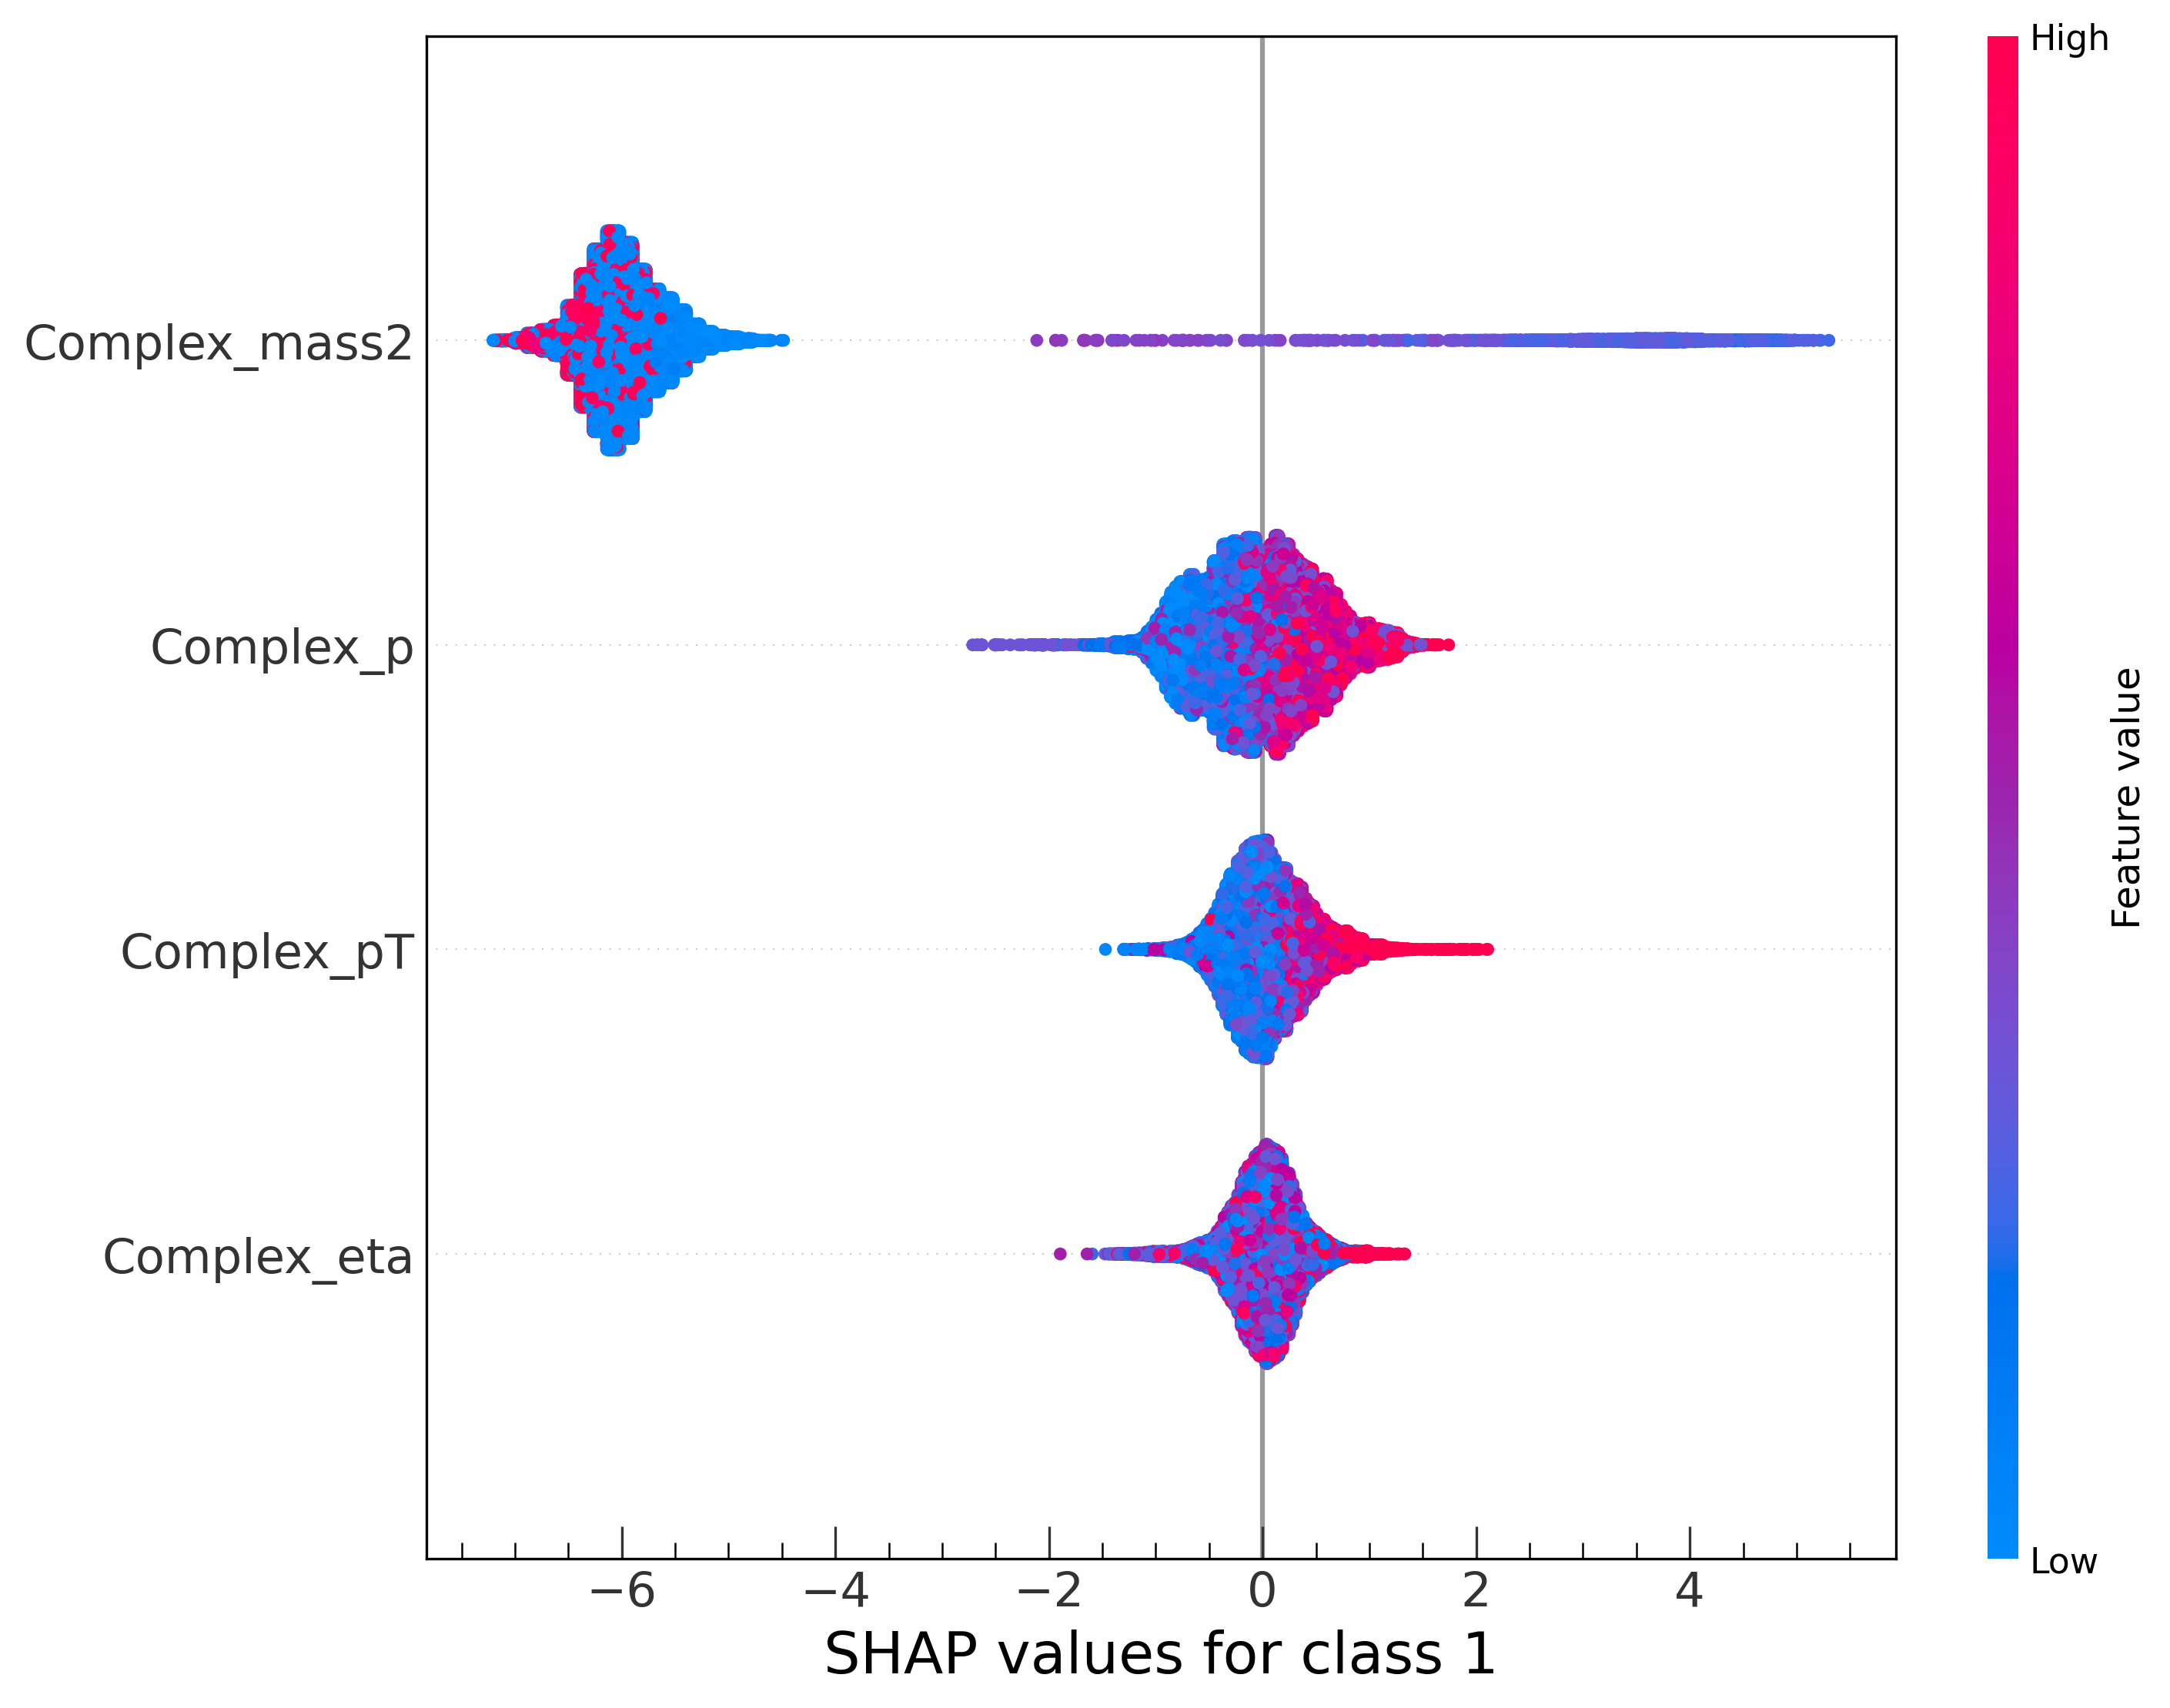

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


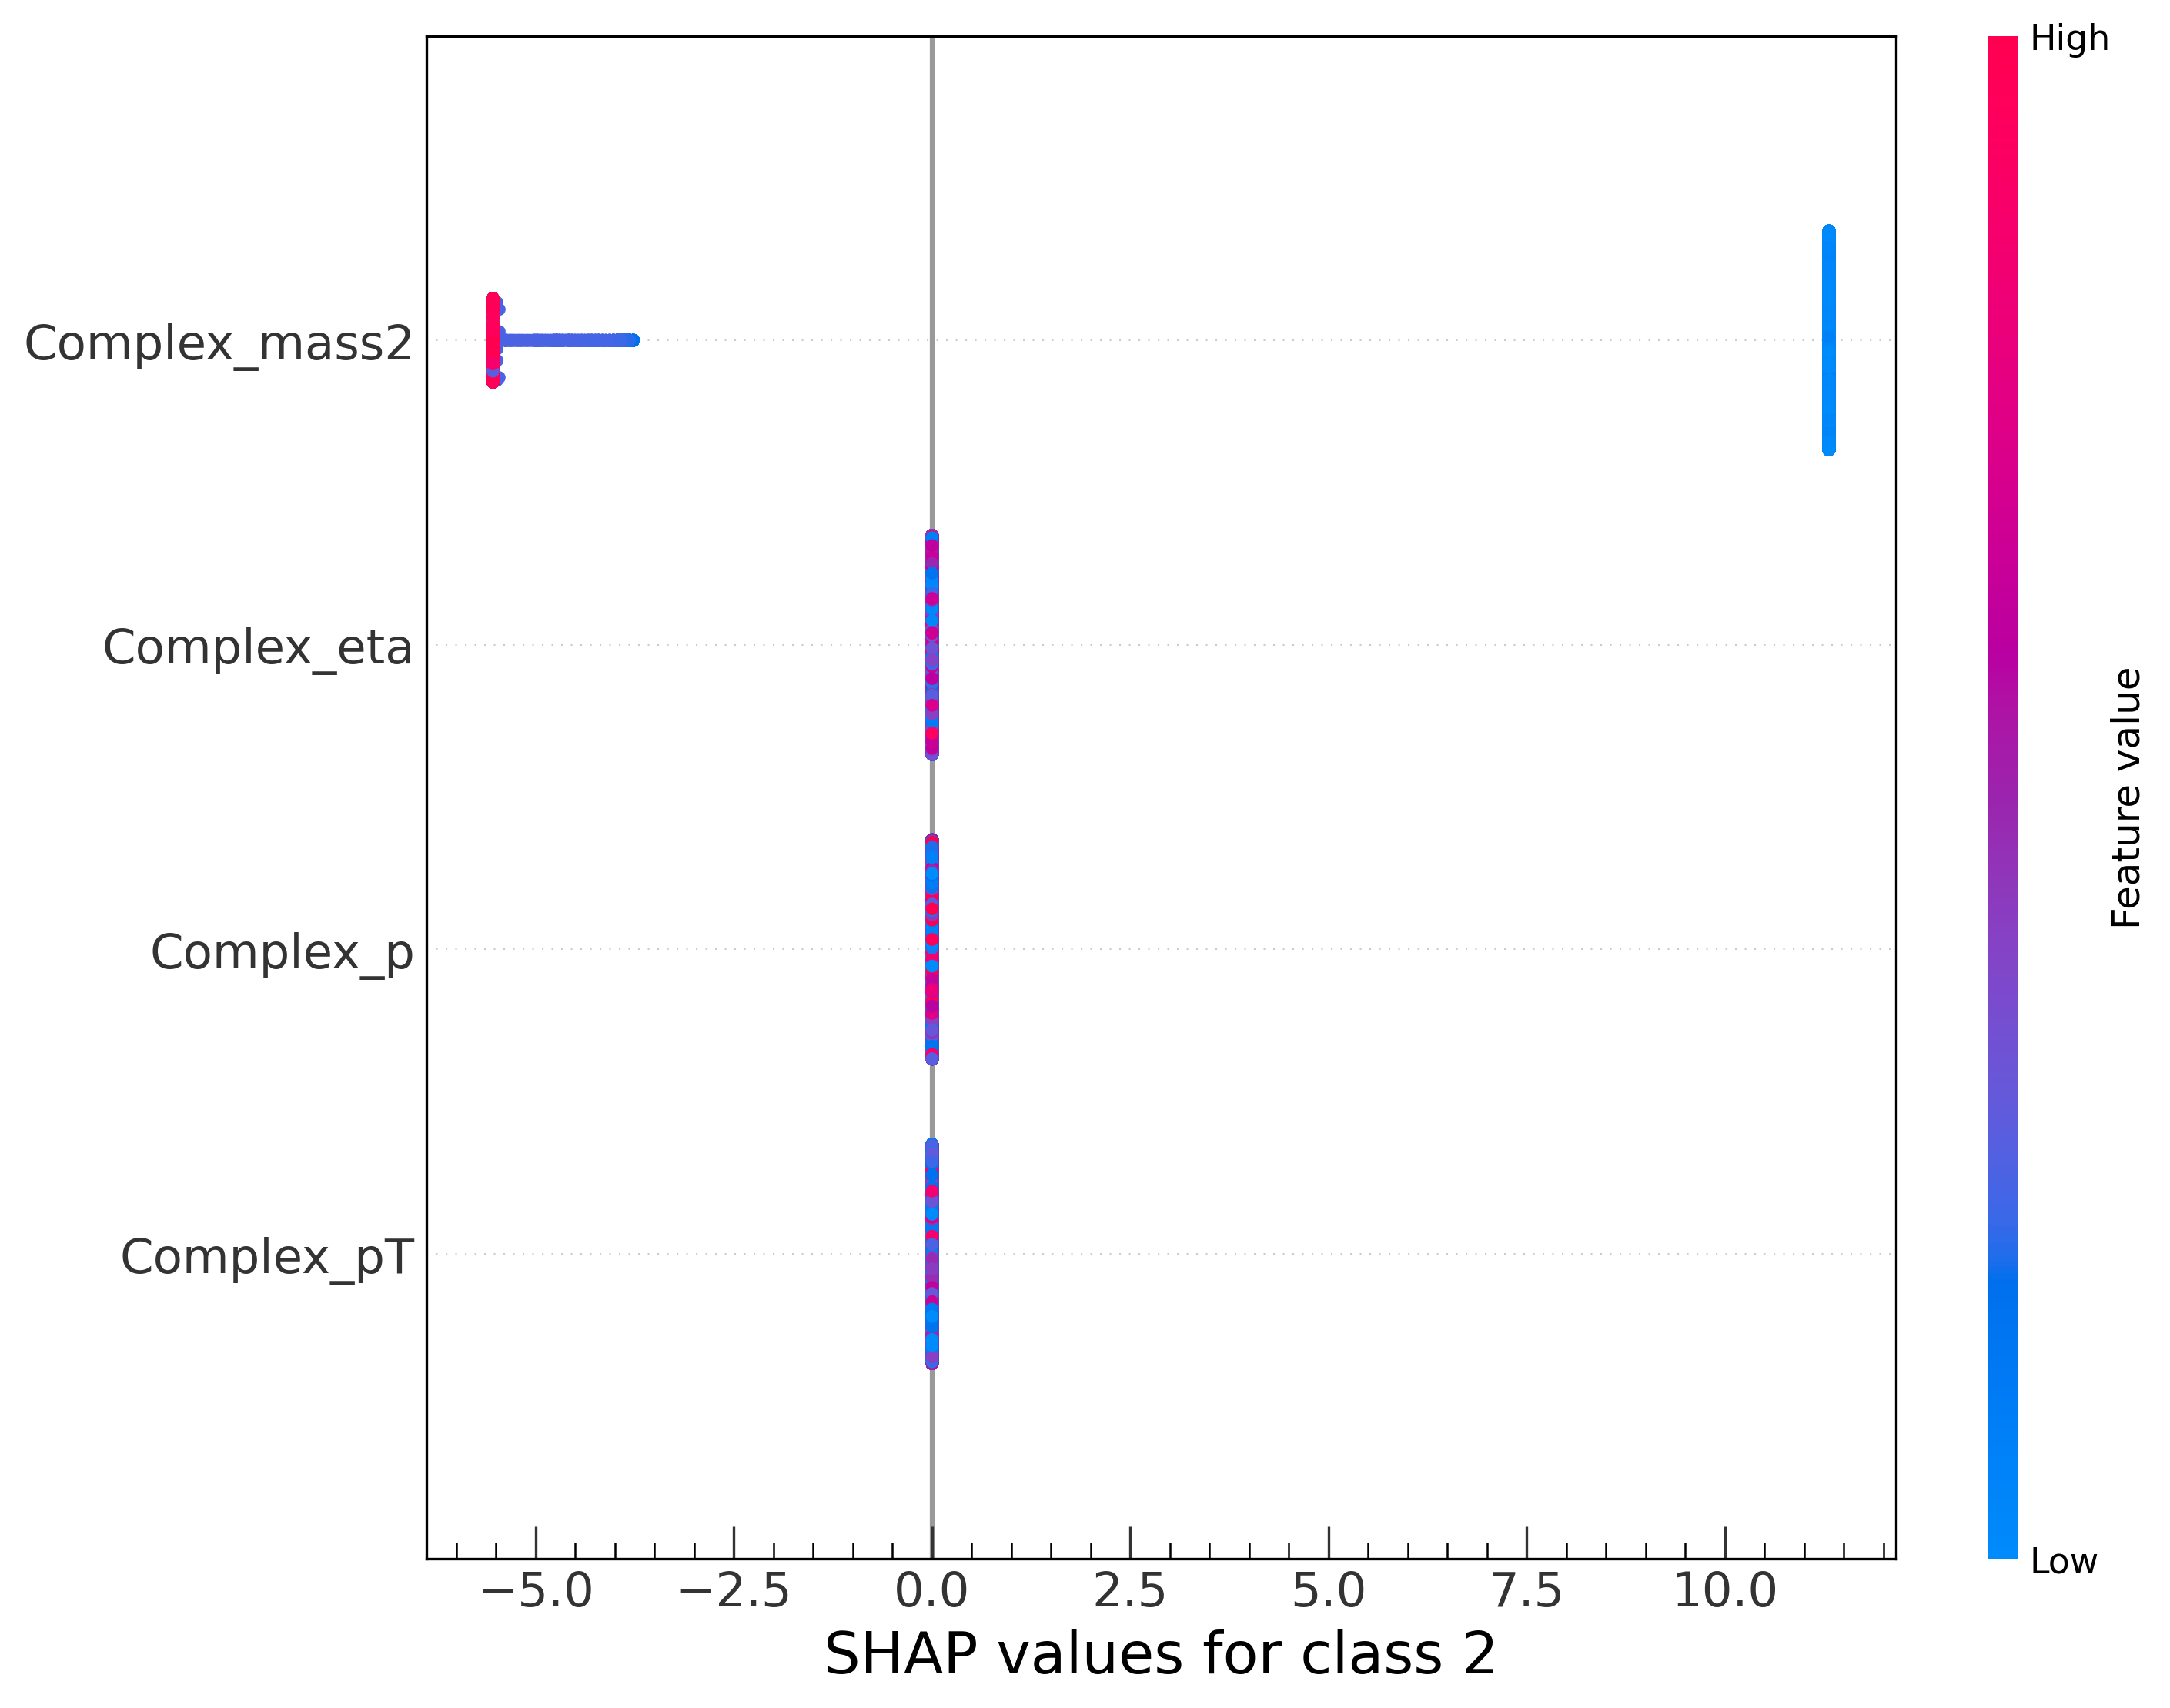

In [11]:
importlib.reload(plotting_tools)
plotting_tools.plot_shap_summary(
        train_test_data[2][features_for_train],
        y_pred_test,
        model_hdl
    )